Epoch  0
Iter: 50 loss: 0.14346081018447876
Iter: 100 loss: 0.14095978438854218
Iter: 150 loss: 0.13970421254634857
Iter: 200 loss: 0.13809047639369965
Iter: 250 loss: 0.13597840070724487
Iter: 300 loss: 0.13317465782165527
Iter: 350 loss: 0.12918639183044434
Epoch  1
Iter: 50 loss: 0.12563298642635345
Iter: 100 loss: 0.1220618262887001
Iter: 150 loss: 0.11803220957517624
Iter: 200 loss: 0.1142464280128479
Iter: 250 loss: 0.11313356459140778
Iter: 300 loss: 0.10655646026134491
Iter: 350 loss: 0.10311674326658249
Epoch  2
Iter: 50 loss: 0.10207627713680267
Iter: 100 loss: 0.10004967451095581
Iter: 150 loss: 0.098991163074970245
Iter: 200 loss: 0.098089933395385742
Iter: 250 loss: 0.09737512469291687
Iter: 300 loss: 0.096963182091712952
Epoch  3
Iter: 50 loss: 0.096228420734405518
Iter: 100 loss: 0.095937043428421021
Iter: 150 loss: 0.095647357404232025
Iter: 200 loss: 0.095508985221385956
Iter: 250 loss: 0.094775654375553131
Iter: 300 loss: 0.094268850982189178
Epoch  4
Iter: 50 loss: 0

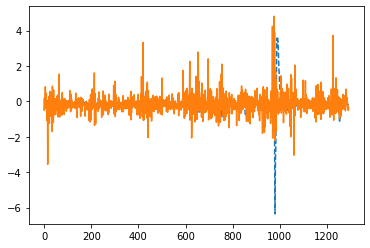

In [ ]:
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
import pandas as pd


# The code for function factory and model training is from https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993 with
# modifications to fit our use case
def function_factory(model, loss, train_x, train_y):
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)
    count = 0
    idx = [] 
    part = [] 

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    @tf.function
    def f(params_1d):
        # calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            loss_value = loss(model(train_x, training=True), train_y)

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        f.iter.assign_add(1)
        if f.iter%50 == 0:
          tf.print("Iter:", f.iter, "loss:", loss_value)

        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


def create_dataset(Betas, time_steps=2):
    Xs, ys = [], []
    for i in range(len(Betas) - time_steps):
        v = Betas[i:(i + time_steps)]
        Xs.append(v)
        ys.append(Betas[i + time_steps])
    return np.array(Xs), np.array(ys)


def get_b_var():
    with open('../TVP-VAR-VDA code/beta/BNB_amount_to_beta.npy', 'rb') as f:
      b_var = np.load(f)
    b_var = np.reshape(b_var,(b_var.shape[0],b_var.shape[1]))
    b_var = b_var * 100

    # beta_pd = pd.read_csv('/content/BNB_amount_to_data_volume_diff_beta.csv', index_col=[0])
    # b_var = beta_pd.to_numpy()
    # b_var = np.reshape(b_var,(b_var.shape[0],b_var.shape[1]))
    b_var = b_var[:,6:12]

    tot = b_var.shape[0]
    test_pct = int(0.1 * tot)
    b_var_train = b_var[:tot-test_pct]
    b_var_test = b_var[tot-test_pct:]
    return b_var_train, b_var_test

if __name__ == "__main__":

    # use float64 by default
    tf.keras.backend.set_floatx("float64")

    # prepare training data
    b_var_train,b_var_test = get_b_var()
    inps, outs = create_dataset(b_var_train,30)
    X_test, Y_test = create_dataset(b_var_test,30)

    input_shape = inps[0].shape
    output_dim = outs[0].shape[0]

    pred_model = tf.keras.models.Sequential([tf.keras.Input(shape=input_shape),

         tf.keras.layers.LSTM(100, 
                            input_shape=input_shape,
                            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0), 
                            ),
        tf.keras.layers.Dense(output_dim, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0) )
    ])


    loss_fun = tf.keras.losses.MeanSquaredError()
    for i in range(7):
        print("Epoch ", i)
        func = function_factory(pred_model, loss_fun, inps, outs)

        # convert initial model parameters to a 1D tf.Tensor
        init_params = tf.dynamic_stitch(func.idx, pred_model.trainable_variables)

        # train the model
        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func, initial_position=init_params, max_iterations=120)

        # save final optimized parameters from results.position to the model
        func.assign_new_model_parameters(results.position)

pred_outs = pred_model.predict(inps)

pyplot.plot(pred_outs[:,1], linestyle="--")
pyplot.plot(outs[:,1])
pyplot.savefig("my_lb.png")
pyplot.close()

pred_test = pred_model.predict(X_test)
pyplot.plot(pred_test[:,1], linestyle="--")
pyplot.plot(Y_test[:, 1])
pyplot.savefig("my_lb_test.png")




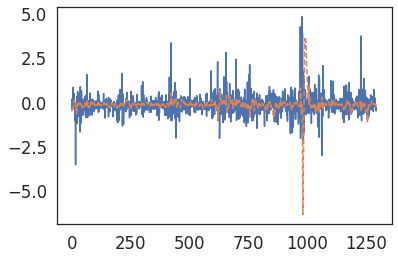

In [ ]:
pyplot.plot(Y_test[:,1])
pyplot.plot(pred_test[:,1], linestyle="--")s
